# Analysis of the State Farm image data

This notebook provides analysis of the provided State Farm data


## Set up the environment
First, let's import what we need and set up environment variables, etc.

In [2]:
# Imports of the relevant libraries
import cv2
import numpy as np
import pandas as pd
import sys
import caffe
import matplotlib.pyplot as plt
# display plots in this notebook
%matplotlib inline

# These are the locations of the images provided by Kaggle
train_image_source_dir = "./imgs/train"
test_image_source_dir = "./imgs/test"
driver_image_list = "./driver_imgs_list.csv"

# These are the locations of the images that we will work with 
# Note that as we're continually mix up training and validation drivers/images, 
# then we will store images in one directory and use code to determine whether to train or validate
train_image_working_dir = "./images/train"
# valid_image_working_dir = "./images/validate" 
test_image_working_dir = "./images/test"

## Process the list of training images
There are only 27 different drivers so in order to avoid overfitting, or testing using very similar data to training, we will split the data based on the driver into train and validation sets.

Initially though, let's get the list of drivers, see how many images are available for each driver, and which classification they have been labelled with.


In [32]:
driver_list = pd.read_csv(driver_image_list)
print driver_list.head()

  subject classname            img
0    p002        c0  img_44733.jpg
1    p002        c0  img_72999.jpg
2    p002        c0  img_25094.jpg
3    p002        c0  img_69092.jpg
4    p002        c0  img_92629.jpg


Seperate the drivers into a training and validation set.  To ensure we don't have overfitting (the training set and the validation set contain the same or similar images) we will split on drivers, so a driver can only appear in training or validation but not both.


In [35]:
driver_ids = []
for id, driver in driver_list.iterrows():
    if driver['subject'] not in driver_ids:
        driver_ids.append(driver['subject'])
print "Found the following drivers: {}".format(driver_ids)
    

Found the following drivers: ['p002', 'p012', 'p014', 'p015', 'p016', 'p021', 'p022', 'p024', 'p026', 'p035', 'p039', 'p041', 'p042', 'p045', 'p047', 'p049', 'p050', 'p051', 'p052', 'p056', 'p061', 'p064', 'p066', 'p072', 'p075', 'p081']


Split into train and validation data tests (split = percentage to have in training set)


In [39]:
def split_drivers_into_train_and_validate(driver_list, split = 0.75):
    driver_valid_list = []
    # Take a random sample of drivers into the training list
    driver_train_list = np.random.choice(driver_list, int(len(driver_list)*split), replace = False)
    # Take the remaining drivers into the validation list
    driver_valid_list = [ driver for driver in driver_list if driver not in driver_train_list]
    return driver_train_list, driver_valid_list
    
#X_train, X_test, y_train, y_test = train_test_split(X_all.ix[rows], student_data[target_col].ix[rows], test_size=test_size)

training_list, validation_list = split_drivers_into_train_and_validate(driver_ids)
print "Driver train list: {}".format(training_list)
print "Driver validation list: {}".format(validation_list)

Driver train list: ['p035' 'p022' 'p051' 'p002' 'p015' 'p056' 'p052' 'p012' 'p061' 'p047'
 'p064' 'p026' 'p075' 'p072' 'p045' 'p042' 'p066' 'p014' 'p049']
Driver validation list: ['p016', 'p021', 'p024', 'p039', 'p041', 'p050', 'p081']


Now we have a list of the drivers, their classification and their images, let's loads images one by one
and get the dimensions of the image (put this into the dataframe too!)

(480, 640, 3)
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Found the following numbers of images per class {'c9': 165, 'c8': 144, 'c3': 362, 'c2': 365, 'c1': 357, 'c0': 339, 'c7': 221, 'c6': 287, 'c5': 375, 'c4': 385}
Found the following numbers of images per driver {'p015': 576, 'p014': 876, 'p012': 823, 'p002': 725}
Total number of images found 3000
['./imgs/train/c0/img_44733.jpg', './imgs/train/c0/img_72999.jpg', './imgs/train/c0/img_25094.jpg', './imgs/train/c0/img_69092.jpg', './imgs/train/c0/img_92629.jpg', './imgs/train/c0/img_3370.jpg', './imgs/train/c0/img_67639.jpg', './imgs/train/c0/img_58560.jpg', './imgs/train/c0/img_35779.jpg', './imgs/train/c0/img_10012.jpg', './imgs/train/c0/img_70354.jpg', './imgs/train/c0/img_54617.jpg', './imgs/train/c0/img_26684.jpg', './imgs/train/c0/img_8

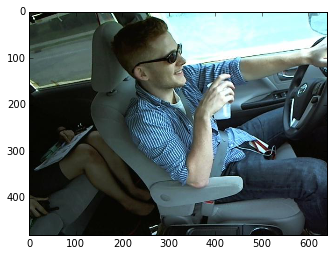

In [54]:
def split_image_data(driver_list, filter, render = True):
    '''Split the data based on a filter (train, valid, test, etc.).  
    render is used if we want to see the first image only as a sample of the data'''
    image_list = []
    class_list = []
    class_count = dict()
    driver_count = dict()
    total = 0
    # for idx, driver in driver_list.iterrows():
    for driver_row in [ drvr for drvr in driver_list.iterrows() if drvr[1]['subject'] in filter ]:
        driver = driver_row[1]  # Drop the index created by the Pandas Dataframe
        image_list.append(train_image_source_dir + '/' + driver['classname'] + '/' + driver['img'])
        class_list.append(driver['classname'])
        # Display the first image if render is set to True (by default we do this!)
        if render == True:
            image = caffe.io.load_image(img_filename)            
            #image = caffe.io.resize_image(image, (120, 160), interp_order = 3 )
            print image.shape
            plt.imshow(image)
            render = False
        # Track how many images we get for each class
        if driver['classname'] in class_count:
            class_count[driver['classname']] += 1
        else:
            class_count[driver['classname']] = 1
        # Track the number of drivers
        if driver['subject'] in driver_count:
            driver_count[driver['subject']] += 1
        else:
            driver_count[driver['subject']] = 1
        # Keep a running total and track progress
        total += 1
        if total % 25 == 0:
            print ".",
    # Print some useful stats   
    print 
    print "Found the following numbers of images per class {}".format(class_count) 
    print "Found the following numbers of images per driver {}".format(driver_count)
    print "Total number of images found {}".format(total)
    #Return a list of images and their classification
    return image_list, class_list

train_image_list, train_class_list = split_image_data(driver_list.head(3000), training_list)
print train_image_list
print train_class_list



## Create an inital CNN based on the AlexNet example
Starting with no pre-loaded weights though as we'll train this with our own data

In [3]:
#caffe.set_device(0)     #Needed for GPU (https://github.com/BVLC/caffe/blob/master/matlab/%2Bcaffe/set_device.m)
caffe.set_mode_cpu()    #Try GPU later, currently crashes so need to debug CUDA/GPU driver install 

model_def = './model/state-farm-train-test.prototxt'
model_weights = './model/caffenet-kaggle-state-farm.caffemodel'

#net = caffe.Net(model_def,      # defines the structure of the model
#                model_weights,  # contains the trained weights
#                caffe.TEST)     # use test mode (e.g., don't perform dropout)



OR Try to set up a Lenet Mnist model...

In [4]:
from caffe import layers as L, params as P

def lenet(lmdb, batch_size):
    # our version of LeNet: a series of linear and simple nonlinear transformations
    n = caffe.NetSpec()
    
    n.data, n.label = L.Data(batch_size=batch_size, backend=P.Data.LMDB, source=lmdb,
                             transform_param=dict(scale=1./255), ntop=2)
    
    n.conv1 = L.Convolution(n.data, kernel_size=5, num_output=20, weight_filler=dict(type='xavier'))
    n.pool1 = L.Pooling(n.conv1, kernel_size=2, stride=2, pool=P.Pooling.MAX)
    n.conv2 = L.Convolution(n.pool1, kernel_size=5, num_output=50, weight_filler=dict(type='xavier'))
    n.pool2 = L.Pooling(n.conv2, kernel_size=2, stride=2, pool=P.Pooling.MAX)
    n.fc1 =   L.InnerProduct(n.pool2, num_output=500, weight_filler=dict(type='xavier'))
    n.relu1 = L.ReLU(n.fc1, in_place=True)
    n.score = L.InnerProduct(n.relu1, num_output=10, weight_filler=dict(type='xavier'))
    n.loss =  L.SoftmaxWithLoss(n.score, n.label)
    
    return n.to_proto()
    
with open('model/lenet_auto_train.prototxt', 'w') as f:
    f.write(str(lenet('model/mnist_train_lmdb', 64)))
    
with open('model/lenet_auto_test.prototxt', 'w') as f:
    f.write(str(lenet('model/mnist_test_lmdb', 100)))

In [ ]:
solver = caffe.SGDSolver('./model/lenet_auto_train.prototxt')

# just print the weight sizes (we'll omit the biases)
#[(k, v[0].data.shape) for k, v in solver.net.params.items()]

To get an idea of the architecture of our net, we can check the dimensions of the intermediate features (blobs) and parameters (these will also be useful to refer to when manipulating data later).

In [1]:
# just print the weight sizes (we'll omit the biases)
[(k, v[0].data.shape) for k, v in solver.net.params.items()]

NameError: name 'solver' is not defined